# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



In [1]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
import PIL
from pathlib import Path

from torchvision import transforms
from torchvision import datasets, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from collections import Counter

from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.sampler import WeightedRandomSampler, SubsetRandomSampler
import torch

# # в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# # мы будем игнорировать warnings
# import warnings
# warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Fri Dec 16 10:59:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Загрузка датасета

Загружу по своему

In [4]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [6]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c journey-springfield

100% 519M/521M [00:32<00:00, 20.2MB/s]
100% 521M/521M [00:32<00:00, 16.7MB/s]


In [8]:
!unzip journey-springfield.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1037.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1038.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1039.jpg  
  in

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [9]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [49]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            # как я понял сериализованные лейблы мы пишем в файл
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):

        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]) 
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [50]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
TRAIN_DIR = Path('/content/train/simpsons_dataset')
TEST_DIR = Path('/content/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [14]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [16]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

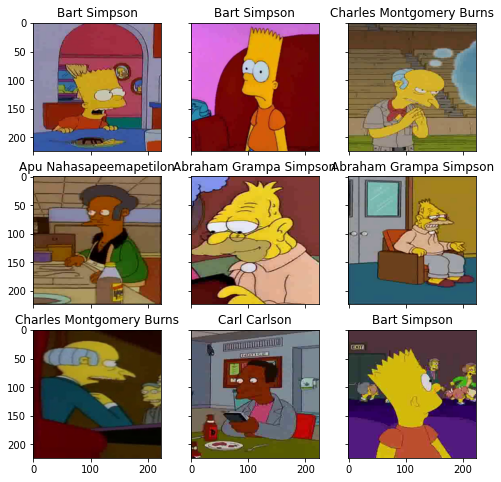

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

## Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [17]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

## Вспомогательные функции

In [25]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
  
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

In [26]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [27]:
def modelsaver(epoch, model, optimizer, scheduler, loss, path_to_save):
  torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'scheduler' : scheduler.state_dict(),
              'history': loss,
              }, path_to_save)

In [28]:
def train(train_files, val_files, model, optimizer, epochs, batch_size, path_to_save, scheduler = False):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    lowest_loss = float('inf')

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        opt = optimizer
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            #сохраню модель
            if val_loss < lowest_loss:
              modelsaver(epoch, model, opt, scheduler, history, path_to_save)
              lowest_loss = val_loss
              print(f'new model was saved with val_loss = lowest_loss = {lowest_loss}')

            #lr scheduler
            if scheduler:
              scheduler.step()
              
    return history

In [29]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Запустим обучение сети

In [23]:
#кол-во классов на выходе
n_classes = len(np.unique(train_val_labels))
print("we will classify {} classes".format(n_classes))

we will classify 42 classes


In [24]:
#инициализация модели
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print(simple_cnn)

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_features=42, bias=True)


Обучение:

In [27]:
#куда сохраняем модель
PATH = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/10. Продвинутое обучение нейросетей/HW_10/best_model_0.pt'

#optimizer
oprimizer = torch.optim.Adam(simple_cnn.parameters())

batch_size = 64
epochs = 2

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, optimizer = oprimizer, epochs=epochs, batch_size=batch_size, path_to_save = PATH)

Загрузка модели если уже тренировал

In [34]:
# # почистим кеш
# torch.cuda.empty_cache()
# import gc
# gc.collect()

# simple_cnn = SimpleCnn(n_classes).to(DEVICE)
# optimizer = torch.optim.Adam(simple_cnn.parameters())

# checkpoint = torch.load(PATH, map_location = DEVICE)
# simple_cnn.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# history = checkpoint['history']

# # simple_cnn.eval()
# # # - or -
# simple_cnn.train()

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_features=42, bias=True)


Построим кривые обучения

In [33]:
loss, acc, val_loss, val_acc = zip(*history)

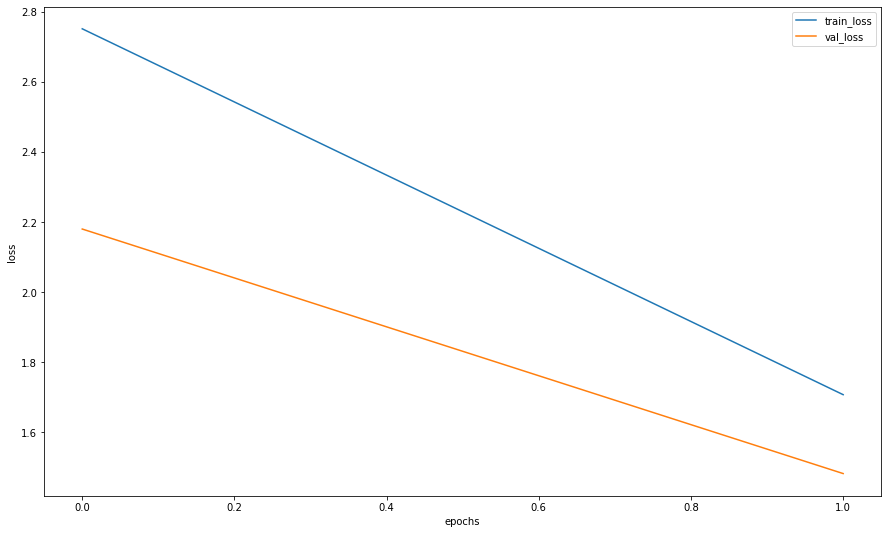

In [34]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

### Одна картинка

In [35]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [36]:
#рандомный индекс для выбора картинки
random_characters = int(np.random.uniform(0,1000))

#вытаскиваем картинку и лейбл по индексу
ex_img, true_label = val_dataset[random_characters]

#предикт для этой картинки
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

### Много картинок

In [37]:
#несколько индексов
idxs = list(map(int, np.random.uniform(0,1000, 20)))

#несколько картинок по индексам
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

#предикты для них
probs_ims = predict(simple_cnn, imgs)

In [38]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [39]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [40]:
actual_labels

[2, 0, 4, 4, 0, 2, 2, 2, 0, 6, 2, 4, 4, 0, 4, 6, 0, 6, 4, 2]

In [41]:
actual_labels_transformed = label_encoder.inverse_transform(actual_labels)
actual_labels_transformed

array(['apu_nahasapeemapetilon', 'abraham_grampa_simpson', 'bart_simpson',
       'bart_simpson', 'abraham_grampa_simpson', 'apu_nahasapeemapetilon',
       'apu_nahasapeemapetilon', 'apu_nahasapeemapetilon',
       'abraham_grampa_simpson', 'charles_montgomery_burns',
       'apu_nahasapeemapetilon', 'bart_simpson', 'bart_simpson',
       'abraham_grampa_simpson', 'bart_simpson',
       'charles_montgomery_burns', 'abraham_grampa_simpson',
       'charles_montgomery_burns', 'bart_simpson',
       'apu_nahasapeemapetilon'], dtype='<U24')

In [42]:
y_pred

array([ 2, 28, 20, 28, 15,  2, 11,  2, 15,  0, 28,  4, 11, 11, 22, 15,  0,
        6,  6,  2])

In [43]:
preds_class

['apu_nahasapeemapetilon',
 'ned_flanders',
 'lisa_simpson',
 'ned_flanders',
 'homer_simpson',
 'apu_nahasapeemapetilon',
 'edna_krabappel',
 'apu_nahasapeemapetilon',
 'homer_simpson',
 'abraham_grampa_simpson',
 'ned_flanders',
 'bart_simpson',
 'edna_krabappel',
 'edna_krabappel',
 'marge_simpson',
 'homer_simpson',
 'abraham_grampa_simpson',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'apu_nahasapeemapetilon']

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [44]:
from sklearn.metrics import f1_score

f1_score(actual_labels_transformed, preds_class, average = 'macro')

0.19682539682539685

То же самое только через цифры

In [45]:
f1_score(actual_labels, y_pred, average = 'macro')

0.19682539682539685

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

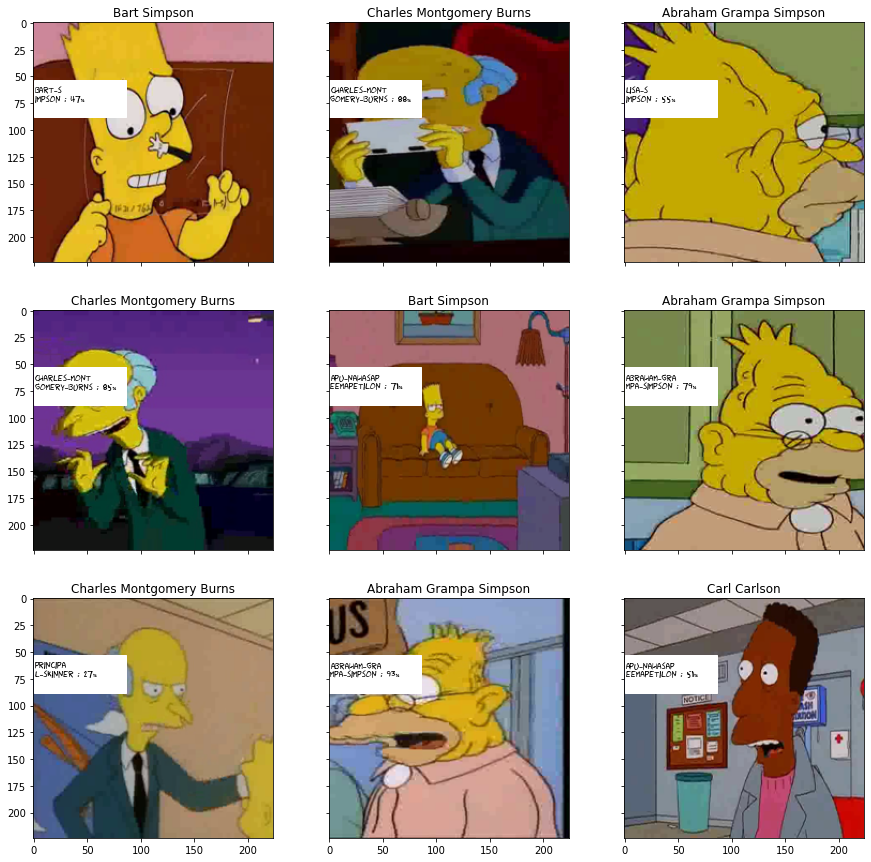

In [46]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15, 15), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Все картинки

In [ ]:
all_imgs = [val_dataset[i][0].unsqueeze(0) for i in range(val_dataset.__len__())]

In [48]:
probs_all_ims = predict(simple_cnn, all_imgs)

In [49]:
y_pred = np.argmax(probs_all_ims,-1)

array([ 0,  0,  9, ..., 15, 20, 15])

In [ ]:
actual_labels = [val_dataset[i][1] for i in range(val_dataset.__len__())]

In [51]:
f1_score(actual_labels, y_pred, average = 'macro')

0.34856176147806217

In [52]:
from sklearn.metrics import classification_report
print(classification_report(actual_labels, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.68      0.52       228
           1       1.00      0.10      0.18        10
           2       0.54      0.86      0.66       156
           3       0.00      0.00      0.00        26
           4       0.60      0.29      0.39       336
           5       0.50      0.08      0.14        24
           6       0.61      0.51      0.56       298
           7       0.83      0.63      0.72       247
           8       1.00      0.08      0.15        12
           9       0.73      0.49      0.58       117
          10       0.00      0.00      0.00         2
          11       0.39      0.73      0.50       114
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         7
          14       0.50      0.07      0.12        30
          15       0.56      0.62      0.59       562
          16       0.82      0.73      0.77       125
          17       0.79    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cls_report = classification_report(actual_labels, y_pred,output_dict= True)

Класс который не был обнаружне и его метрики

In [ ]:
unfoundclass = []
for key, item in cls_report.items():
  if len(key) <= 2: # чтобы не трогать последние 3 строчки из словаря
    if item['f1-score'] == 0:
      unfoundclass.append(int(key))
      print(f'undefined class is {key}, {item}')

undefined class is 10, {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}
undefined class is 19, {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}


In [ ]:
unfoundclass

[10, 19]

Индексы тех картинок что не были обнаружены сеткой

In [ ]:
no_imgs_indx = [i for i in range(val_dataset.__len__()) if val_dataset[i][1] in unfoundclass]
no_imgs_indx

[1454, 1455, 2680]

Нарисуем их

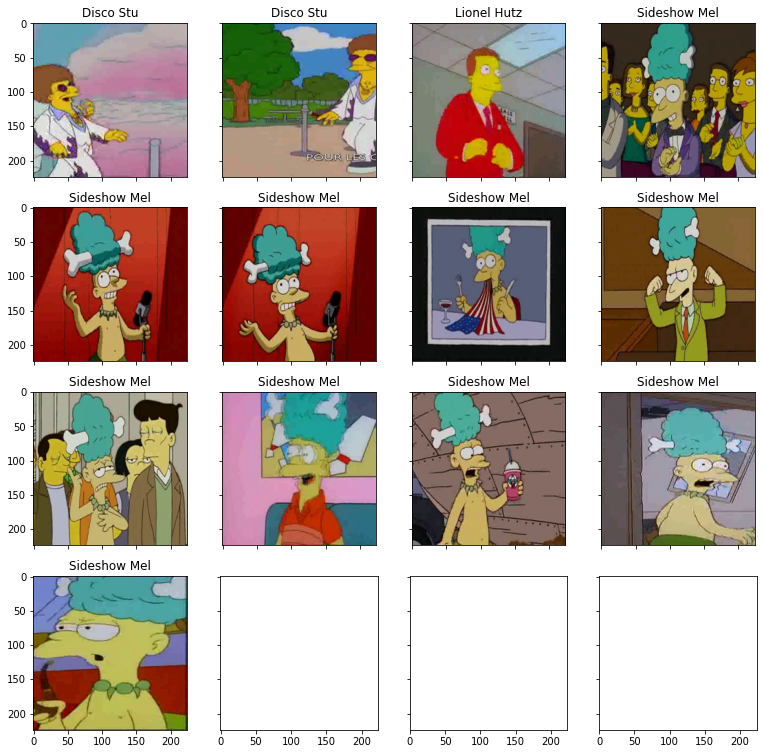

In [57]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(13, 13), \
                        sharey=True, sharex=True)
for i in range(len(no_imgs_indx)):
    # random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[no_imgs_indx[i]]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=ax.flatten()[i])

Как видно несмотря на то что Sideshow Mel 10 раз встречается, его модель все равно не смогла научиться распознавать. Остальные понятно встречаются 2 раза как Диско Стю или  1 раз как Лионель Хатз

## Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(sbd_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

In [ ]:
import pandas as pd
my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('gdrive/My Drive/simpsons/simple_cnn_baseline.csv', index=False)

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


# Оптимизация

## Adam - amsgrad

In [59]:
#куда сохраняем модель
PATH = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/10. Продвинутое обучение нейросетей/HW_10/best_model.pt'

#optimizer
optimizer = torch.optim.Adam(simple_cnn.parameters(), amsgrad=True)

batch_size = 64
epochs = 2

history = train(train_dataset, val_dataset, model=simple_cnn, optimizer = optimizer, epochs=epochs, batch_size=batch_size, path_to_save = PATH)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 1.1272613384653956


epoch:  50%|█████     | 1/2 [02:22<02:22, 142.79s/it]


Epoch 001 train_loss: 1.1273     val_loss 1.0774 train_acc 0.6906 val_acc 0.7186
new model was saved with lowest_loss = 1.0774328412561414
loss 0.782888479001644


epoch: 100%|██████████| 2/2 [04:42<00:00, 141.22s/it]


Epoch 002 train_loss: 0.7829     val_loss 0.9751 train_acc 0.7808 val_acc 0.7516
new model was saved with lowest_loss = 0.9751306396428984


In [60]:
loss, acc, val_loss, val_acc = zip(*history)

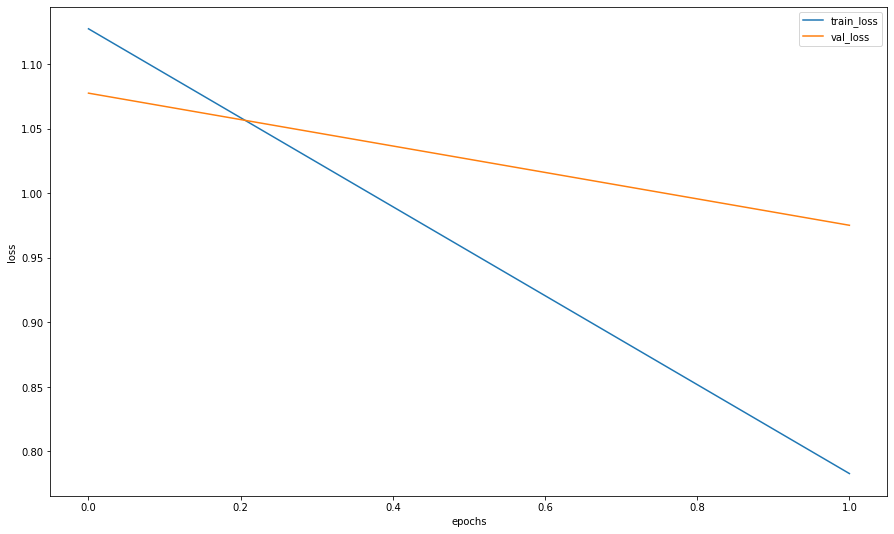

In [61]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

F1-macro на всех картинках val_dataset

In [ ]:
all_imgs = [val_dataset[i][0].unsqueeze(0) for i in range(val_dataset.__len__())]

In [62]:
probs_all_ims = predict(simple_cnn, all_imgs)

In [63]:
y_pred = np.argmax(probs_all_ims,-1)

array([ 0,  0, 29, ..., 32, 20, 32])

In [ ]:
actual_labels = [val_dataset[i][1] for i in range(val_dataset.__len__())]

In [64]:
f1_score(actual_labels, y_pred, average = 'macro')

0.5744377971841333

In [65]:
print(classification_report(actual_labels, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.68      0.77       228
           1       1.00      0.10      0.18        10
           2       0.78      0.87      0.82       156
           3       0.59      0.38      0.47        26
           4       0.67      0.73      0.70       336
           5       0.75      0.62      0.68        24
           6       0.89      0.45      0.59       298
           7       0.80      0.82      0.81       247
           8       0.27      0.50      0.35        12
           9       0.76      0.64      0.69       117
          10       0.00      0.00      0.00         2
          11       0.80      0.75      0.78       114
          12       1.00      0.43      0.60         7
          13       1.00      0.29      0.44         7
          14       0.69      0.30      0.42        30
          15       0.70      0.83      0.76       562
          16       0.92      0.85      0.88       125
          17       0.94    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cls_report = classification_report(actual_labels, y_pred,output_dict= True)

Класс который не был обнаружне и его метрики

In [69]:
unfoundclass = []
for key, item in cls_report.items():
  if len(key) <= 2: # чтобы не трогать последние 3 строчки из словаря
    if item['f1-score'] == 0:
      unfoundclass.append(int(key))
      print(f'undefined class is {key}, {item}')

undefined class is 10, {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}
undefined class is 19, {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}


In [70]:
unfoundclass

[10, 19]

Индексы тех картинок что не были обнаружены сеткой

In [71]:
no_imgs_indx = [i for i in range(val_dataset.__len__()) if val_dataset[i][1] in unfoundclass]
no_imgs_indx

[1454, 1455, 2680]

Нарисуем их

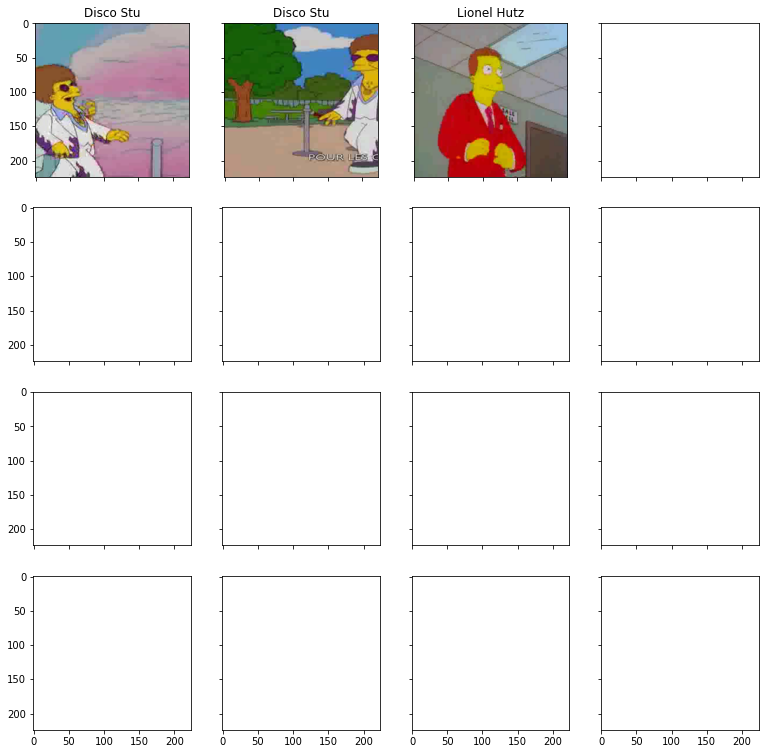

In [72]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(13, 13), \
                        sharey=True, sharex=True)
for i in range(len(no_imgs_indx)):
    # random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[no_imgs_indx[i]]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=ax.flatten()[i])

## Adam - amsgrad + weight decay

In [73]:
#куда сохраняем модель
PATH = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/10. Продвинутое обучение нейросетей/HW_10/best_model.pt'

#optimizer
optimizer = torch.optim.Adam(simple_cnn.parameters(), amsgrad=True, weight_decay=1e-3)

batch_size = 64
epochs = 2

history = train(train_dataset, val_dataset, model=simple_cnn, optimizer = optimizer, epochs=epochs, batch_size=batch_size, path_to_save = PATH)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 0.6075488510644544


epoch:  50%|█████     | 1/2 [02:26<02:26, 146.88s/it]


Epoch 001 train_loss: 0.6075     val_loss 0.9103 train_acc 0.8278 val_acc 0.7700
new model was saved with lowest_loss = 0.9102722661933418
loss 0.4553388255790158


epoch: 100%|██████████| 2/2 [04:55<00:00, 147.87s/it]


Epoch 002 train_loss: 0.4553     val_loss 0.8902 train_acc 0.8692 val_acc 0.7734
new model was saved with lowest_loss = 0.8901926163821717


In [ ]:
all_imgs = [val_dataset[i][0].unsqueeze(0) for i in range(val_dataset.__len__())]

In [74]:
probs_all_ims = predict(simple_cnn, all_imgs)

In [75]:
y_pred = np.argmax(probs_all_ims,-1)

In [ ]:
actual_labels = [val_dataset[i][1] for i in range(val_dataset.__len__())]

In [76]:
f1_score(actual_labels, y_pred, average = 'macro')

0.6094758053677138

In [77]:
print(classification_report(actual_labels, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.61      0.72       228
           1       0.67      0.20      0.31        10
           2       0.83      0.86      0.84       156
           3       0.55      0.42      0.48        26
           4       0.57      0.81      0.67       336
           5       0.78      0.75      0.77        24
           6       0.64      0.78      0.70       298
           7       0.84      0.86      0.85       247
           8       0.43      0.25      0.32        12
           9       0.89      0.57      0.70       117
          10       0.00      0.00      0.00         2
          11       0.86      0.70      0.77       114
          12       1.00      0.57      0.73         7
          13       0.50      0.29      0.36         7
          14       0.73      0.27      0.39        30
          15       0.73      0.86      0.79       562
          16       0.82      0.90      0.86       125
          17       0.89    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
cls_report = classification_report(actual_labels, y_pred,output_dict= True)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Класс который не был обнаружне и его метрики

In [80]:
unfoundclass = []
for key, item in cls_report.items():
  if len(key) <= 2: # чтобы не трогать последние 3 строчки из словаря
    if item['f1-score'] == 0:
      unfoundclass.append(int(key))
      print(f'undefined class is {key}, {item}')

undefined class is 10, {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}
undefined class is 19, {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}


In [81]:
unfoundclass

[10, 19]

Индексы тех картинок что не были обнаружены сеткой

In [82]:
no_imgs_indx = [i for i in range(val_dataset.__len__()) if val_dataset[i][1] in unfoundclass]
no_imgs_indx

[1454, 1455, 2680]

Нарисуем их

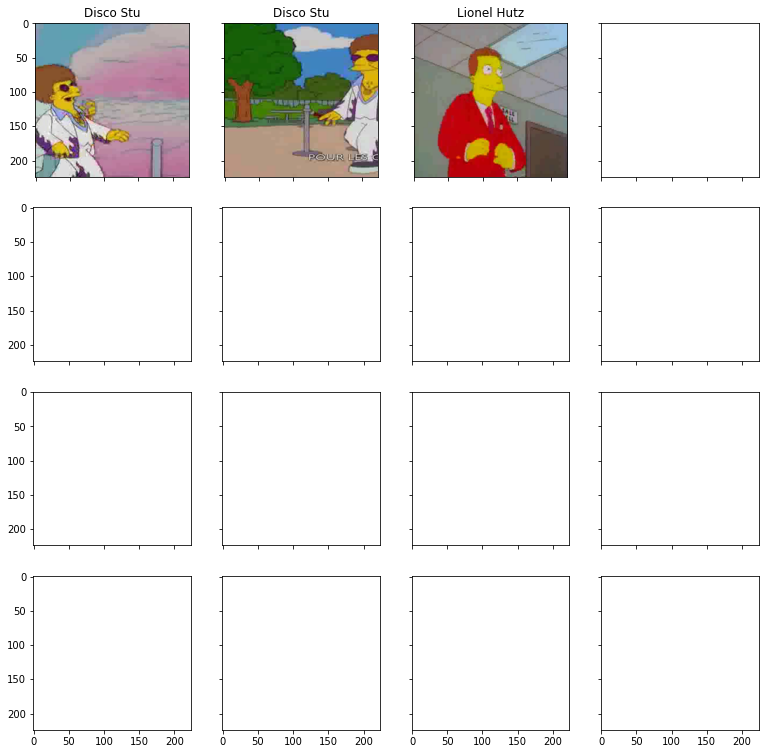

In [83]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(13, 13), \
                        sharey=True, sharex=True)
for i in range(len(no_imgs_indx)):
    # random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[no_imgs_indx[i]]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=ax.flatten()[i])

## Adam - amsgrad + weight decay +  lr scheduler

In [86]:
#куда сохраняем модель
PATH = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/10. Продвинутое обучение нейросетей/HW_10/best_model.pt'

#optimizer
optimizer = torch.optim.Adam(simple_cnn.parameters(), amsgrad=True, weight_decay=1e-3)

#scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


batch_size = 64
epochs = 2

history = train(train_dataset, val_dataset, model=simple_cnn, optimizer = optimizer, epochs=epochs, batch_size=batch_size, path_to_save = PATH, scheduler = scheduler)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 0.38513755825296525


epoch:  50%|█████     | 1/2 [02:27<02:27, 147.71s/it]


Epoch 001 train_loss: 0.3851     val_loss 0.8218 train_acc 0.8892 val_acc 0.7979
new model was saved with lowest_loss = 0.8217554635385725
loss 0.25258307703538446


epoch: 100%|██████████| 2/2 [04:44<00:00, 142.26s/it]


Epoch 002 train_loss: 0.2526     val_loss 0.9193 train_acc 0.9254 val_acc 0.8003
new model was saved with lowest_loss = 0.9193470192903046


In [ ]:
all_imgs = [val_dataset[i][0].unsqueeze(0) for i in range(val_dataset.__len__())]

In [87]:
probs_all_ims = predict(simple_cnn, all_imgs)

In [88]:
y_pred = np.argmax(probs_all_ims,-1)

In [ ]:
actual_labels = [val_dataset[i][1] for i in range(val_dataset.__len__())]

In [89]:
f1_score(actual_labels, y_pred, average = 'macro')

0.6387885496716459

In [90]:
print(classification_report(actual_labels, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.67      0.79       228
           1       1.00      0.10      0.18        10
           2       0.85      0.85      0.85       156
           3       0.47      0.35      0.40        26
           4       0.75      0.71      0.73       336
           5       0.88      0.62      0.73        24
           6       0.67      0.81      0.73       298
           7       0.85      0.83      0.84       247
           8       0.71      0.42      0.53        12
           9       0.74      0.76      0.75       117
          10       0.00      0.00      0.00         2
          11       0.76      0.80      0.78       114
          12       1.00      0.57      0.73         7
          13       1.00      0.29      0.44         7
          14       1.00      0.30      0.46        30
          15       0.73      0.88      0.80       562
          16       0.96      0.88      0.92       125
          17       0.93    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
cls_report = classification_report(actual_labels, y_pred,output_dict= True)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Класс который не был обнаружне и его метрики

In [93]:
unfoundclass = []
for key, item in cls_report.items():
  if len(key) <= 2: # чтобы не трогать последние 3 строчки из словаря
    if item['f1-score'] == 0:
      unfoundclass.append(int(key))
      print(f'undefined class is {key}, {item}')

undefined class is 10, {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}
undefined class is 19, {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}


In [94]:
unfoundclass

[10, 19]

Индексы тех картинок что не были обнаружены сеткой

In [95]:
no_imgs_indx = [i for i in range(val_dataset.__len__()) if val_dataset[i][1] in unfoundclass]
no_imgs_indx

[1454, 1455, 2680]

Нарисуем их

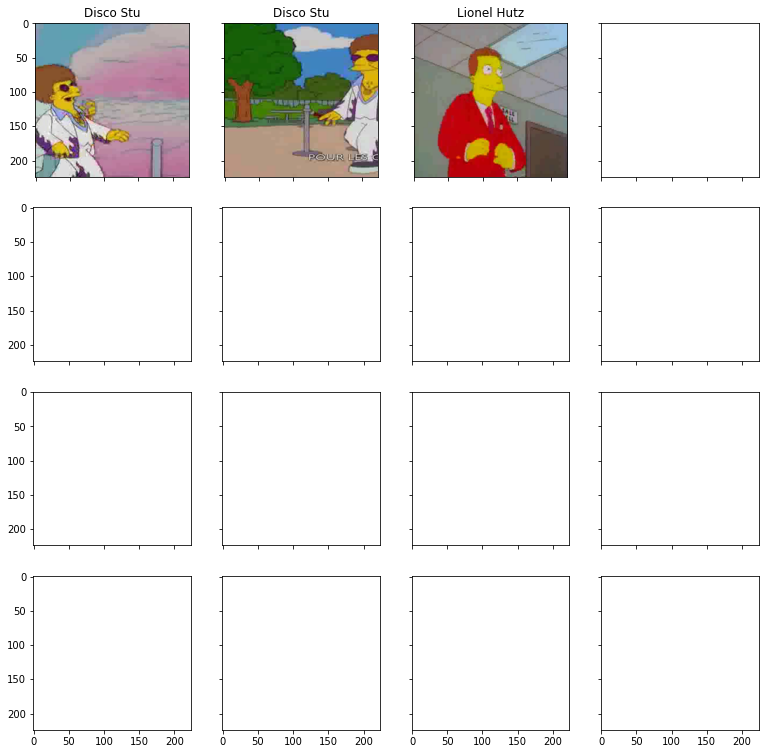

In [96]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(13, 13), \
                        sharey=True, sharex=True)
for i in range(len(no_imgs_indx)):
    # random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[no_imgs_indx[i]]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=ax.flatten()[i])

## Adam - amsgrad + weight decay +  lr scheduler + larger batchsize + more epochs

In [40]:
#куда сохраняем модель
PATH = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/10. Продвинутое обучение нейросетей/HW_10/best_model.pt'

#optimizer
optimizer = torch.optim.Adam(simple_cnn.parameters(), amsgrad=True, weight_decay=1e-3)

#scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

batch_size = 256
epochs = 10

history = train(train_dataset, val_dataset, model=simple_cnn, optimizer = optimizer,
                epochs=epochs, batch_size=batch_size, path_to_save = PATH, scheduler = scheduler)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.6852493902529658


epoch:  10%|█         | 1/10 [02:25<21:51, 145.69s/it]


Epoch 001 train_loss: 0.6852     val_loss 1.0119 train_acc 0.8101 val_acc 0.7480
new model was saved with val_loss = lowest_loss = 1.0119463879049941
loss 0.5090880750740354


epoch:  20%|██        | 2/10 [05:01<20:12, 151.61s/it]


Epoch 002 train_loss: 0.5091     val_loss 1.0405 train_acc 0.8563 val_acc 0.7474
loss 0.42338630294707164


epoch:  30%|███       | 3/10 [07:40<18:04, 154.92s/it]


Epoch 003 train_loss: 0.4234     val_loss 1.0787 train_acc 0.8778 val_acc 0.7572
loss 0.346677548779493


epoch:  40%|████      | 4/10 [10:10<15:18, 153.04s/it]


Epoch 004 train_loss: 0.3467     val_loss 1.1031 train_acc 0.9033 val_acc 0.7606
loss 0.27394380046612243


epoch:  50%|█████     | 5/10 [12:39<12:38, 151.72s/it]


Epoch 005 train_loss: 0.2739     val_loss 1.1582 train_acc 0.9244 val_acc 0.7560
loss 0.22265553771804053


epoch:  60%|██████    | 6/10 [15:09<10:04, 151.13s/it]


Epoch 006 train_loss: 0.2227     val_loss 1.2355 train_acc 0.9376 val_acc 0.7623
loss 0.18291299996637858


epoch:  70%|███████   | 7/10 [17:39<07:32, 150.67s/it]


Epoch 007 train_loss: 0.1829     val_loss 1.2893 train_acc 0.9482 val_acc 0.7639
loss 0.14310230222281564


epoch:  80%|████████  | 8/10 [20:07<04:59, 149.69s/it]


Epoch 008 train_loss: 0.1431     val_loss 1.3799 train_acc 0.9614 val_acc 0.7629
loss 0.1065787631223153


epoch:  90%|█████████ | 9/10 [22:35<02:29, 149.13s/it]


Epoch 009 train_loss: 0.1066     val_loss 1.4429 train_acc 0.9734 val_acc 0.7661
loss 0.08582732455603362


epoch: 100%|██████████| 10/10 [25:01<00:00, 150.17s/it]


Epoch 010 train_loss: 0.0858     val_loss 1.5352 train_acc 0.9797 val_acc 0.7682


In [27]:
all_imgs = [val_dataset[i][0].unsqueeze(0) for i in range(val_dataset.__len__())]

In [28]:
probs_all_ims = predict(simple_cnn, all_imgs)

In [29]:
y_pred = np.argmax(probs_all_ims,-1)

In [30]:
actual_labels = [val_dataset[i][1] for i in range(val_dataset.__len__())]

In [33]:
f1_score(actual_labels, y_pred, average = 'macro')

0.5653100472894051

In [34]:
print(classification_report(actual_labels, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.72      0.69       228
           1       0.56      0.50      0.53        10
           2       0.76      0.81      0.78       156
           3       0.31      0.31      0.31        26
           4       0.60      0.61      0.60       336
           5       0.63      0.71      0.67        24
           6       0.71      0.66      0.69       298
           7       0.86      0.83      0.84       247
           8       0.60      0.25      0.35        12
           9       0.60      0.68      0.63       117
          10       0.00      0.00      0.00         2
          11       0.72      0.70      0.71       114
          12       0.75      0.43      0.55         7
          13       0.50      0.29      0.36         7
          14       0.73      0.37      0.49        30
          15       0.72      0.77      0.74       562
          16       0.89      0.86      0.88       125
          17       0.82    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
cls_report = classification_report(actual_labels, y_pred,output_dict= True)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Класс который не был обнаружне и его метрики

In [36]:
unfoundclass = []
for key, item in cls_report.items():
  if len(key) <= 2: # чтобы не трогать последние 3 строчки из словаря
    if item['f1-score'] == 0:
      unfoundclass.append(int(key))
      print(f'undefined class is {key}, {item}')

undefined class is 10, {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}
undefined class is 19, {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}


In [37]:
unfoundclass

[10, 19]

Индексы тех картинок что не были обнаружены сеткой

In [38]:
no_imgs_indx = [i for i in range(val_dataset.__len__()) if val_dataset[i][1] in unfoundclass]
no_imgs_indx

[1454, 1455, 2680]

Нарисуем их

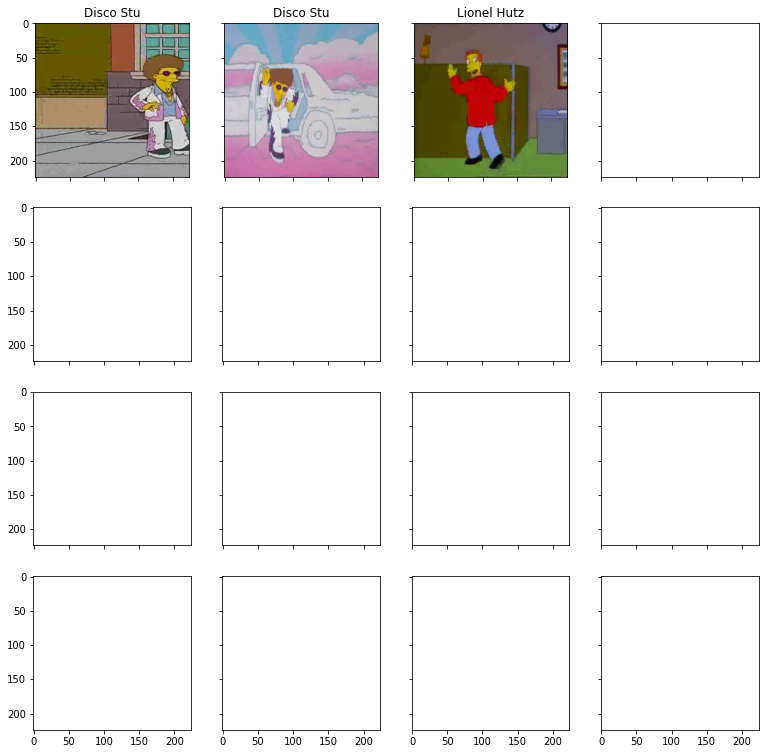

In [39]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(13, 13), \
                        sharey=True, sharex=True)
for i in range(len(no_imgs_indx)):
    # random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[no_imgs_indx[i]]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=ax.flatten()[i])

# Нормализация

## Adam - amsgrad + weight decay +  lr scheduler + larger batchsize + more epochs + batch norm

Добавлб батч норм слои в модель

In [26]:
class SimpleBatchCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [27]:
#кол-во классов на выходе
n_classes = len(np.unique(train_val_labels))

In [28]:
#инициализация модели
sb_cnn = SimpleBatchCnn(n_classes).to(DEVICE)

In [29]:
#куда сохраняем модель
PATH = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/10. Продвинутое обучение нейросетей/HW_10/best_model.pt'

#optimizer
optimizer = torch.optim.Adam(sb_cnn.parameters(), amsgrad=True, weight_decay=1e-3)

#scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

batch_size = 512
epochs = 8

history = train(train_dataset, val_dataset, model=sb_cnn, optimizer = optimizer,
                epochs=epochs, batch_size=batch_size, path_to_save = PATH, scheduler = scheduler)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 2.2586417828511944


epoch:  12%|█▎        | 1/8 [02:46<19:25, 166.45s/it]


Epoch 001 train_loss: 2.2586     val_loss 1.8808 train_acc 0.4128 val_acc 0.5006
new model was saved with val_loss = lowest_loss = 1.8807506901096378
loss 1.3839175935246868


epoch:  25%|██▌       | 2/8 [05:15<15:37, 156.22s/it]


Epoch 002 train_loss: 1.3839     val_loss 1.3256 train_acc 0.6266 val_acc 0.6460
new model was saved with val_loss = lowest_loss = 1.3255781094263563
loss 0.9678132192208756


epoch:  38%|███▊      | 3/8 [07:39<12:32, 150.43s/it]


Epoch 003 train_loss: 0.9678     val_loss 1.1284 train_acc 0.7330 val_acc 0.6998
new model was saved with val_loss = lowest_loss = 1.1284078030263736
loss 0.7037766299222532


epoch:  50%|█████     | 4/8 [10:03<09:52, 148.09s/it]


Epoch 004 train_loss: 0.7038     val_loss 1.0323 train_acc 0.8073 val_acc 0.7285
new model was saved with val_loss = lowest_loss = 1.0323413247409832
loss 0.542387416335578


epoch:  62%|██████▎   | 5/8 [12:28<07:21, 147.05s/it]


Epoch 005 train_loss: 0.5424     val_loss 1.0139 train_acc 0.8526 val_acc 0.7335
new model was saved with val_loss = lowest_loss = 1.0138517677396774
loss 0.41421828121734705


epoch:  75%|███████▌  | 6/8 [14:52<04:52, 146.05s/it]


Epoch 006 train_loss: 0.4142     val_loss 0.9518 train_acc 0.8906 val_acc 0.7679
new model was saved with val_loss = lowest_loss = 0.9517892852374329
loss 0.29678128687915806


epoch:  88%|████████▊ | 7/8 [17:16<02:25, 145.14s/it]


Epoch 007 train_loss: 0.2968     val_loss 0.9489 train_acc 0.9224 val_acc 0.7715
new model was saved with val_loss = lowest_loss = 0.9489493914856727
loss 0.22039043488559604


epoch: 100%|██████████| 8/8 [19:38<00:00, 147.26s/it]


Epoch 008 train_loss: 0.2204     val_loss 0.9858 train_acc 0.9451 val_acc 0.7696


In [30]:
all_imgs = [val_dataset[i][0].unsqueeze(0) for i in range(val_dataset.__len__())]

In [41]:
probs_all_ims = predict(sb_cnn, all_imgs)

In [42]:
y_pred = np.argmax(probs_all_ims,-1)

In [43]:
actual_labels = [val_dataset[i][1] for i in range(val_dataset.__len__())]

In [44]:
f1_score(actual_labels, y_pred, average = 'macro')

0.6353283093460337

In [45]:
print(classification_report(actual_labels, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       228
           1       0.40      0.20      0.27        10
           2       0.75      0.87      0.80       156
           3       0.48      0.54      0.51        26
           4       0.63      0.71      0.67       336
           5       0.67      0.50      0.57        24
           6       0.82      0.67      0.74       298
           7       0.88      0.89      0.89       247
           8       1.00      0.42      0.59        12
           9       0.60      0.78      0.68       117
          10       0.00      0.00      0.00         2
          11       0.65      0.80      0.72       114
          12       1.00      0.29      0.44         7
          13       0.75      0.43      0.55         7
          14       0.89      0.53      0.67        30
          15       0.72      0.81      0.76       562
          16       0.88      0.80      0.84       125
          17       0.94    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
cls_report = classification_report(actual_labels, y_pred,output_dict= True)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Класс который не был обнаружне и его метрики

In [47]:
unfoundclass = []
for key, item in cls_report.items():
  if len(key) <= 2: # чтобы не трогать последние 3 строчки из словаря
    if item['f1-score'] == 0:
      unfoundclass.append(int(key))
      print(f'undefined class is {key}, {item}')

undefined class is 10, {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}
undefined class is 19, {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}


In [48]:
unfoundclass

[10, 19]

Индексы тех картинок что не были обнаружены сеткой

In [49]:
no_imgs_indx = [i for i in range(val_dataset.__len__()) if val_dataset[i][1] in unfoundclass]
no_imgs_indx

[1454, 1455, 2680]

Нарисуем их

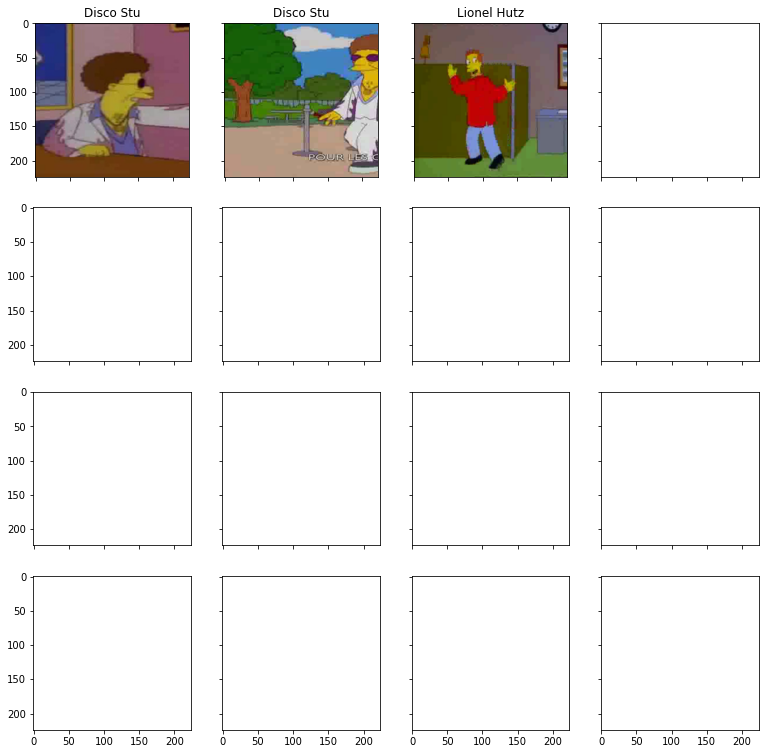

In [50]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(13, 13), \
                        sharey=True, sharex=True)
for i in range(len(no_imgs_indx)):
    # random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[no_imgs_indx[i]]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=ax.flatten()[i])

## Adam - amsgrad + weight decay +  lr scheduler + larger batchsize + more epochs + batch norm + dropout + 2 linear layers

In [63]:
class SimpleBatchDropCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )

        self.linear1 = nn.Sequential(
            nn.Linear(96 * 5 * 5, 1200),
            nn.ReLU(),
            nn.BatchNorm1d(1200),
            nn.Dropout(0.2)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(1200, 600),
            nn.ReLU(),
            nn.BatchNorm1d(600),
            nn.Dropout(0.2)
        )

        self.out = nn.Linear(600, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.linear2(x)

        logits = self.out(x)
        return logits

In [64]:
#кол-во классов на выходе
n_classes = len(np.unique(train_val_labels))

In [65]:
n_classes

42

In [66]:
torch.cuda.empty_cache()
import gc
gc.collect()

703

In [67]:
#инициализация модели
sbd_cnn = SimpleBatchDropCnn(n_classes).to(DEVICE)

In [68]:
#куда сохраняем модель
PATH = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/10. Продвинутое обучение нейросетей/HW_10/best_model.pt'

#optimizer
optimizer = torch.optim.Adam(sbd_cnn.parameters(), amsgrad=True, weight_decay=1e-3)

#scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

batch_size = 512
epochs = 8

history = train(train_dataset, val_dataset, model=sbd_cnn, optimizer = optimizer,
                epochs=epochs, batch_size=batch_size, path_to_save = PATH, scheduler = scheduler)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([339, 96, 5, 5])
loss 2.1538012547738705
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 

epoch:  12%|█▎        | 1/8 [02:38<18:28, 158.32s/it]

torch.Size([114, 96, 5, 5])

Epoch 001 train_loss: 2.1538     val_loss 1.7389 train_acc 0.4674 val_acc 0.5481
new model was saved with val_loss = lowest_loss = 1.738917938570599
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size

epoch:  25%|██▌       | 2/8 [05:13<15:39, 156.52s/it]

torch.Size([114, 96, 5, 5])

Epoch 002 train_loss: 1.0481     val_loss 1.1109 train_acc 0.7169 val_acc 0.7083
new model was saved with val_loss = lowest_loss = 1.11089191301934
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size(

epoch:  38%|███▊      | 3/8 [07:44<12:50, 154.00s/it]

torch.Size([114, 96, 5, 5])

Epoch 003 train_loss: 0.5363     val_loss 0.9592 train_acc 0.8549 val_acc 0.7474
new model was saved with val_loss = lowest_loss = 0.9592029456651343
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Siz

epoch:  50%|█████     | 4/8 [10:18<10:16, 154.12s/it]

torch.Size([114, 96, 5, 5])

Epoch 004 train_loss: 0.2428     val_loss 0.9131 train_acc 0.9380 val_acc 0.7784
new model was saved with val_loss = lowest_loss = 0.9131462959374095
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Siz

epoch:  62%|██████▎   | 5/8 [12:53<07:42, 154.17s/it]

torch.Size([114, 96, 5, 5])

Epoch 005 train_loss: 0.0894     val_loss 0.9498 train_acc 0.9803 val_acc 0.7877
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([339, 96, 5, 5])
loss 0.032212564809146

epoch:  75%|███████▌  | 6/8 [15:25<05:07, 153.51s/it]

torch.Size([114, 96, 5, 5])

Epoch 006 train_loss: 0.0322     val_loss 0.9666 train_acc 0.9962 val_acc 0.7994
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([339, 96, 5, 5])
loss 0.012422480039368

epoch:  88%|████████▊ | 7/8 [17:56<02:32, 152.60s/it]

torch.Size([114, 96, 5, 5])

Epoch 007 train_loss: 0.0124     val_loss 0.9973 train_acc 0.9990 val_acc 0.8061
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([512, 96, 5, 5])
torch.Size([339, 96, 5, 5])
loss 0.005790061384256

epoch: 100%|██████████| 8/8 [20:26<00:00, 153.37s/it]

torch.Size([114, 96, 5, 5])

Epoch 008 train_loss: 0.0058     val_loss 0.9871 train_acc 0.9998 val_acc 0.8074


In [69]:
all_imgs = [val_dataset[i][0].unsqueeze(0) for i in range(val_dataset.__len__())]

In [70]:
probs_all_ims = predict(sbd_cnn, all_imgs)

Streaming output truncated to the last 5000 lines.
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1, 96, 5, 5])
torch.Size([1

In [71]:
y_pred = np.argmax(probs_all_ims,-1)

In [72]:
actual_labels = [val_dataset[i][1] for i in range(val_dataset.__len__())]

In [73]:
f1_score(actual_labels, y_pred, average = 'macro')

0.6657065290671911

In [74]:
print(classification_report(actual_labels, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       228
           1       0.80      0.40      0.53        10
           2       0.86      0.90      0.88       156
           3       0.55      0.42      0.48        26
           4       0.73      0.77      0.75       336
           5       0.75      0.62      0.68        24
           6       0.73      0.78      0.76       298
           7       0.85      0.87      0.86       247
           8       0.88      0.58      0.70        12
           9       0.86      0.71      0.78       117
          10       0.50      0.50      0.50         2
          11       0.74      0.80      0.77       114
          12       0.83      0.71      0.77         7
          13       0.80      0.57      0.67         7
          14       0.80      0.67      0.73        30
          15       0.82      0.78      0.80       562
          16       0.83      0.91      0.87       125
          17       0.83    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
cls_report = classification_report(actual_labels, y_pred,output_dict= True)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Класс который не был обнаружне и его метрики

In [76]:
unfoundclass = []
for key, item in cls_report.items():
  if len(key) <= 2: # чтобы не трогать последние 3 строчки из словаря
    if item['f1-score'] == 0:
      unfoundclass.append(int(key))
      print(f'undefined class is {key}, {item}')

undefined class is 19, {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}
undefined class is 26, {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}


In [77]:
unfoundclass

[19, 26]

Индексы тех картинок что не были обнаружены сеткой

In [78]:
no_imgs_indx = [i for i in range(val_dataset.__len__()) if val_dataset[i][1] in unfoundclass]
no_imgs_indx

[2680, 3724, 3725, 3726, 3727]

Нарисуем их

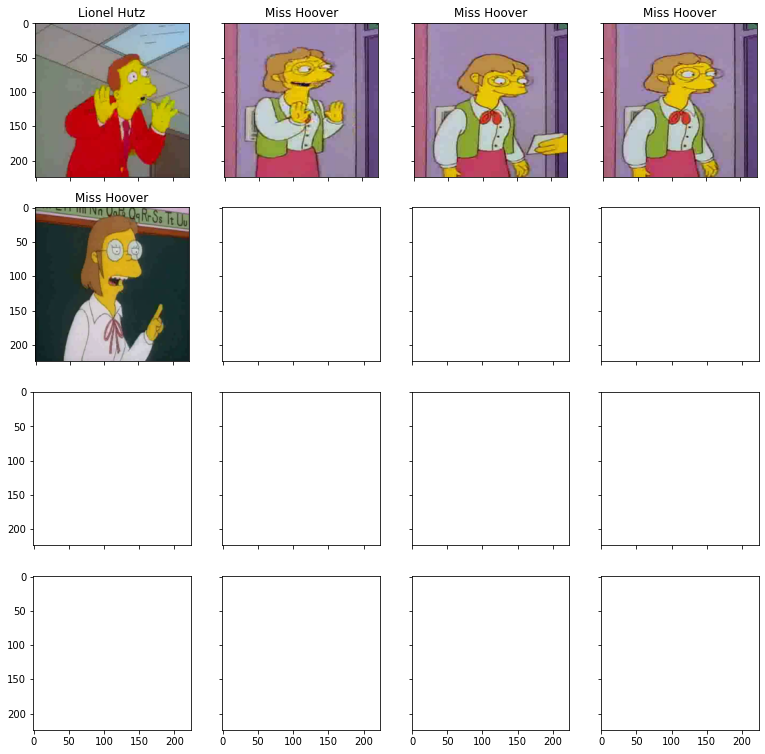

In [79]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(13, 13), \
                        sharey=True, sharex=True)
for i in range(len(no_imgs_indx)):
    # random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[no_imgs_indx[i]]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=ax.flatten()[i])

In [63]:
# почистим кеш
torch.cuda.empty_cache()
import gc
gc.collect()

# старая моедль
PATH = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/10. Продвинутое обучение нейросетей/HW_10/best_model.pt'

model = SimpleBatchDropCnn(n_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())

checkpoint = torch.load(PATH, map_location = DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
history = checkpoint['history']

model.eval()
# # - or -
# model.train()

SimpleBatchDropCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

Результаты на тест

In [ ]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)
    
    def __len__(self):
        return len(self.files)

In [65]:
test_dataset = TestDataset(test_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=512)
probs = predict(model, test_loader)
preds = [train_data.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

In [66]:
import pandas as pd

In [67]:
answers = pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
})
answers.head(10)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
5,img102.jpg,kent_brockman
6,img103.jpg,edna_krabappel
7,img104.jpg,chief_wiggum
8,img105.jpg,lisa_simpson
9,img106.jpg,kent_brockman


In [68]:
def get_number(name):
    return int(name[3:-4:])


answers['Num'] = answers['Id'].apply(get_number)
answers = answers.sort_values(by='Num', ignore_index=True).drop('Num', axis=1)
answers

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img2.jpg,mayor_quimby
3,img3.jpg,nelson_muntz
4,img4.jpg,bart_simpson
...,...,...
986,img986.jpg,sideshow_bob
987,img987.jpg,nelson_muntz
988,img988.jpg,sideshow_bob
989,img989.jpg,charles_montgomery_burns


In [69]:
answers.to_csv('simpson_classification_test_2.csv', index=False)

## Adam - amsgrad + weight decay +  lr scheduler + larger batchsize + more epochs + batch norm + dropout + 2 linear layers + augmentation

In [12]:
# можно из коробки приводить все изображения к единому формату, конвертировать в торч тензор и нормализовывать
transform_train = transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.AutoAugment(), # аугментация
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], # это среднее и стандартное отклонение всего датасета (обычно imagenet), на котором обучали большую сеть
                              std=[0.229, 0.224, 0.225]),
])
# отдельный для теста
transform_val = transforms.Compose([
         transforms.Resize((224, 224)),                           
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

In [13]:
# при загрузке сразу указываем как предобрабатывать
train_data = datasets.ImageFolder(TRAIN_DIR, transform=transform_train)
val_data = datasets.ImageFolder(TRAIN_DIR, transform=transform_val)

In [14]:
train_data

Dataset ImageFolder
    Number of datapoints: 20933
    Root location: /content/train/simpsons_dataset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               AutoAugment(policy=AutoAugmentPolicy.IMAGENET, fill=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [15]:
VAL_SIZE = 0.2

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(VAL_SIZE * num_train))

np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

In [16]:
train_dataset = torch.utils.data.Subset(dataset=train_data, indices=train_idx)
val_dataset = torch.utils.data.Subset(dataset=val_data, indices=valid_idx)

In [17]:
# подсчитываем, сколько экземпляров каждого класса в train_dataset
class_count = Counter(train_data.targets[i] for i in train_idx) 

class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset) # список из нулей длины len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)

100%|██████████| 16747/16747 [01:43<00:00, 161.52it/s]


In [33]:
train_loader = DataLoader(train_dataset, batch_size=512, sampler=train_sampler, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle = False, pin_memory=True, num_workers=2)

In [34]:
images, labels = next(iter(train_loader))

In [37]:
# размер картинок
images.shape, labels.shape

(torch.Size([512, 3, 224, 224]), torch.Size([512]))

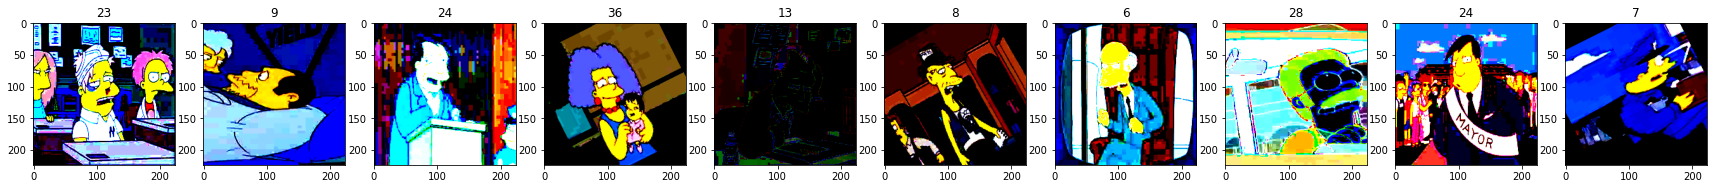

In [38]:
# посмотрим на пару из них
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
      axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)

Вспомогательные функции ( если вдруг выше не прокликали)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
  
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def modelsaver(epoch, model, optimizer, scheduler, loss, path_to_save):
  torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'scheduler' : scheduler.state_dict(),
              'history': loss,
              }, path_to_save)

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [31]:
def train(train_files, val_files, model, optimizer, epochs, batch_size, path_to_save, sampler, scheduler = False):

    # train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_dataset), shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=ImbalancedDatasetSampler(val_dataset), shuffle=False)

    train_loader = DataLoader(train_files, batch_size=batch_size, sampler=sampler, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle = False, pin_memory=True, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    lowest_loss = float('inf')

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        opt = optimizer
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            #сохраню модель
            if val_loss < lowest_loss:
              modelsaver(epoch, model, opt, scheduler, history, path_to_save)
              lowest_loss = val_loss
              print(f'new model was saved with val_loss = lowest_loss = {lowest_loss}')

            #lr scheduler
            if scheduler:
              scheduler.step()
              
    return history

Модель

In [19]:
class SimpleBatchDropCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )

        self.linear1 = nn.Sequential(
            nn.Linear(96 * 5 * 5, 1200),
            nn.ReLU(),
            nn.BatchNorm1d(1200),
            nn.Dropout(0.2)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(1200, 600),
            nn.ReLU(),
            nn.BatchNorm1d(600),
            nn.Dropout(0.2)
        )

        self.out = nn.Linear(600, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.linear2(x)

        logits = self.out(x)
        return logits

In [20]:
#кол-во классов на выходе
n_classes = len(np.unique(train_val_labels))

In [21]:
n_classes

42

In [22]:
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [23]:
#инициализация модели
sbd_cnn = SimpleBatchDropCnn(n_classes).to(DEVICE)

In [32]:
#куда сохраняем модель
PATH = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/10. Продвинутое обучение нейросетей/HW_10/best_model1.pt'

#optimizer
lr = 1e-4
optimizer = torch.optim.Adam(sbd_cnn.parameters(), amsgrad=True, weight_decay=1e-3, lr = lr)

#scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

batch_size = 512
epochs = 8

history = train(train_dataset, val_dataset, model=sbd_cnn, optimizer = optimizer,
                epochs=epochs, batch_size=batch_size, path_to_save = PATH, sampler = train_sampler, scheduler = scheduler)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 2.516348021986071


epoch:  12%|█▎        | 1/8 [07:03<49:27, 423.88s/it]


Epoch 001 train_loss: 2.5163     val_loss 2.2832 train_acc 0.3982 val_acc 0.4386
new model was saved with val_loss = lowest_loss = 2.2831827399267057
loss 1.375860729231713


epoch:  25%|██▌       | 2/8 [14:22<43:14, 432.38s/it]


Epoch 002 train_loss: 1.3759     val_loss 1.4993 train_acc 0.6561 val_acc 0.5999
new model was saved with val_loss = lowest_loss = 1.4992557466742074
loss 0.9398210199722923


epoch:  38%|███▊      | 3/8 [21:30<35:53, 430.69s/it]


Epoch 003 train_loss: 0.9398     val_loss 1.2780 train_acc 0.7565 val_acc 0.6555
new model was saved with val_loss = lowest_loss = 1.2779842043287493
loss 0.728028256205184


epoch:  50%|█████     | 4/8 [28:33<28:30, 427.63s/it]


Epoch 004 train_loss: 0.7280     val_loss 1.1792 train_acc 0.8114 val_acc 0.6873
new model was saved with val_loss = lowest_loss = 1.1791500453452317
loss 0.6121871509249248


epoch:  62%|██████▎   | 5/8 [35:47<21:29, 429.79s/it]


Epoch 005 train_loss: 0.6122     val_loss 1.1209 train_acc 0.8415 val_acc 0.7088
new model was saved with val_loss = lowest_loss = 1.1209097424022785
loss 0.5267925974979991


epoch:  75%|███████▌  | 6/8 [43:05<14:24, 432.50s/it]


Epoch 006 train_loss: 0.5268     val_loss 1.0945 train_acc 0.8624 val_acc 0.7229
new model was saved with val_loss = lowest_loss = 1.0945378459359947
loss 0.4566267786921208


epoch:  88%|████████▊ | 7/8 [50:11<07:10, 430.56s/it]


Epoch 007 train_loss: 0.4566     val_loss 1.0880 train_acc 0.8805 val_acc 0.7296
new model was saved with val_loss = lowest_loss = 1.087987824996806
loss 0.41031470580229545


epoch: 100%|██████████| 8/8 [57:21<00:00, 430.16s/it]


Epoch 008 train_loss: 0.4103     val_loss 1.0514 train_acc 0.8933 val_acc 0.7387
new model was saved with val_loss = lowest_loss = 1.0514071193598016


In [34]:
all_imgs = [val_dataset[i][0].unsqueeze(0) for i in range(val_dataset.__len__())]


In [36]:
probs_all_ims = predict(sbd_cnn, all_imgs)

In [37]:
y_pred = np.argmax(probs_all_ims,-1)

In [38]:
actual_labels = [val_dataset[i][1] for i in range(val_dataset.__len__())]

In [41]:
f1_score(actual_labels, y_pred, average = 'micro')

0.7386526516961299

In [42]:
print(classification_report(actual_labels, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.78      0.69       172
           1       0.25      0.25      0.25         4
           2       0.76      0.85      0.80       121
           3       0.69      0.39      0.50        23
           4       0.69      0.60      0.64       250
           5       0.63      0.60      0.62        20
           6       0.76      0.61      0.68       258
           7       0.79      0.87      0.83       196
           8       0.50      0.29      0.36         7
           9       0.76      0.65      0.70        89
          10       1.00      0.33      0.50         3
          11       0.83      0.79      0.81        94
          12       0.43      0.75      0.55         4
          13       1.00      0.33      0.50         6
          14       0.41      0.78      0.54        18
          15       0.73      0.70      0.71       437
          16       0.87      0.86      0.86       106
          17       0.81    

Класс который не был обнаружне и его метрики

Тут мы видим что обнаружили все картинки после аугментации

In [43]:
cls_report = classification_report(actual_labels, y_pred,output_dict= True)

In [44]:
unfoundclass = []
for key, item in cls_report.items():
  if len(key) <= 2: # чтобы не трогать последние 3 строчки из словаря
    if item['f1-score'] == 0:
      unfoundclass.append(int(key))
      print(f'undefined class is {key}, {item}')

In [45]:
unfoundclass

[]

Индексы тех картинок что не были обнаружены сеткой

In [ ]:
no_imgs_indx = [i for i in range(val_dataset.__len__()) if val_dataset[i][1] in unfoundclass]
no_imgs_indx

Нарисуем их

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(13, 13), \
                        sharey=True, sharex=True)
for i in range(len(no_imgs_indx)):
    # random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[no_imgs_indx[i]]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=ax.flatten()[i])

Результаты на тест

In [53]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)
    
    def __len__(self):
        return len(self.files)

In [55]:
test_dataset = TestDataset(test_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=512)
probs = predict(sbd_cnn, test_loader)
preds = [train_data.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]


In [57]:
import pandas as pd

In [58]:
answers = pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
})
answers.head(10)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
5,img102.jpg,kent_brockman
6,img103.jpg,edna_krabappel
7,img104.jpg,chief_wiggum
8,img105.jpg,lisa_simpson
9,img106.jpg,kent_brockman


In [59]:
def get_number(name):
    return int(name[3:-4:])


answers['Num'] = answers['Id'].apply(get_number)
answers = answers.sort_values(by='Num', ignore_index=True).drop('Num', axis=1)
answers

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img2.jpg,mayor_quimby
3,img3.jpg,nelson_muntz
4,img4.jpg,lisa_simpson
...,...,...
986,img986.jpg,sideshow_bob
987,img987.jpg,nelson_muntz
988,img988.jpg,chief_wiggum
989,img989.jpg,charles_montgomery_burns


In [60]:
answers.to_csv('simpson_classification.csv', index=False)

# Вывод 

Kaggle :  Pavel Zelenin

Последняя модель с аугментацией хоть и нашла все картинки, но почему-то обучалась много дольше чем предыдущие модели.

На Каггл загрузил результаты 2х последних моделей, и предпоследняя дала даже чуть больших результат ( та что училась без аугментации)

Надо еще поработать над аугментациями для улучшения результата